In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sqlalchemy
from collections import defaultdict
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import datetime
import importlib
from simulator.ideal import SimulatorIdeal
from simulator.lennard import SimulatorLennard
from simulator.magnetic import SimulatorMagnetic
from simulator.models import Client, Simulation
from tqdm.notebook import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import logging.config
import logging
import sys
logging.config.fileConfig("/home/amatevosyan/telegramLogConfig")
logger = logging.getLogger("telegram")

matplotlib.rcParams["figure.dpi"] = 150

In [2]:
client = Client()

In [3]:
session = client.Session()
print(session.query(sqlalchemy.func.count(Simulation.id), Simulation.group_name).group_by(Simulation.group_name).all())
session.close()

[(48, 'Dummy'), (231, 'Ensemble 12'), (50, 'BEnsemble 0'), (180, 'Ensemble 13'), (12, 'Armen init 3'), (25, 'Armen init 4'), (2, 'Armen init 2'), (516, 'BEnsemble 1')]


In [4]:
def f(id):
    id = id[0]
    sim = SimulatorMagnetic(id=id)
    name = sim.name
    Bz = sim.Bz
    dfs = sim.get_data_frames()
    data = dict()
    
    for key in ["L", "KE", "PE", "IE"]:
        series = dfs[key].sum(axis=1)
        series.name = name
        data[key] = series

    series = (dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1)
    series.name = name
    data["E"] = series
    return Bz, data

In [5]:
pool = multiprocessing.Pool(cpu_count(), maxtasksperchild=1)

In [6]:
query = (session.query(Simulation.id)
             .where(Simulation.group_name=='Ensemble 14')
#              .where(Simulation.record_interval==0.1)
             .order_by(Simulation.name)).all()[:]
print(len(query))

0


In [16]:
query = (session.query(Simulation.id)
             .where(Simulation.group_name=='BEnsemble 1')
#              .where(Simulaton.name=='subgroup-2')
#              .where(Simulation.record_interval==0.1)
             .order_by(Simulation.name)).all()[:]
print(len(query))

527


In [17]:
pool_result = list(tqdm(pool.imap(f, query), total=len(query)))

data = defaultdict(lambda : defaultdict(list))
for Bz, item in pool_result:
    for key, value in item.items():
        data[Bz][key].append(value)
for Bz in data.keys():
        for key in data[Bz].keys():
            df = pd.concat(data[Bz][key], axis=1)
            data[Bz][key] = df
data = dict(data)

  0%|          | 0/527 [00:00<?, ?it/s]

In [10]:
index = data[0]["L"].index

In [ ]:
data.keys()

In [11]:
def plot_mean_std(df, color, label):
    m = df.mean(axis=1)
    std = df.std(axis=1)
    m.plot(color=color, label=label)
    plt.fill_between(df.index, (m + std), (m - std), color=color, alpha=0.1)

In [14]:
df_diff = {}
for Bz in data.keys():
    if Bz==0:
        continue
    sr = (data[Bz]["L"]-data[0]["L"])[data[Bz]["L"].columns[0]]
    sr.name = Bz
    df_diff[Bz] = sr
df_diff = pd.DataFrame(df_diff)

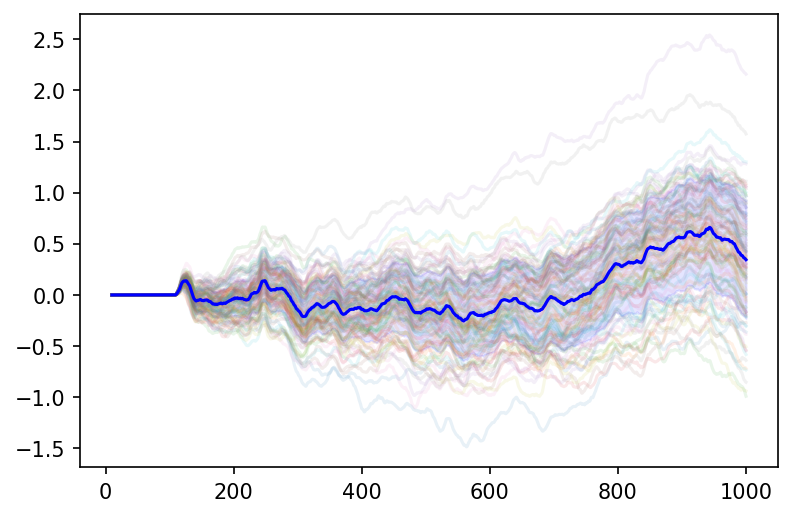

In [15]:
rl = 100
ax = df_diff.rolling(rl).mean().plot(alpha=0.1)
ax.get_legend().remove()
plot_mean_std(df_diff.rolling(rl).mean(), "blue", "a")

In [ ]:
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
data[0]["L"].plot(alpha=0.1, color="blue", ax=ax)
data[1e-7]["L"].plot(alpha=0.1, color="orange", ax=ax)

# plt.xlim(-0.5, 1)
plt.grid()
ax.get_legend().remove()

In [ ]:
fig = plt.figure(figsize=(14,5))
plot_mean_std(data[0]["L"], color="blue", label=r"$B=0$")
plot_mean_std(data[1e-7]["L"], color="orange", label=r"$B\ne 0$")
plot_mean_std(data[1]["L"], color="red", label=r"$B\ne 0$")

# plt.xlim(-0.5, 1)
plt.grid(which="both")
plt.minorticks_on()
plt.legend()
# ax.get_legend().remove()

In [13]:
100/12

8.333333333333334

In [19]:
index[1]

0.05

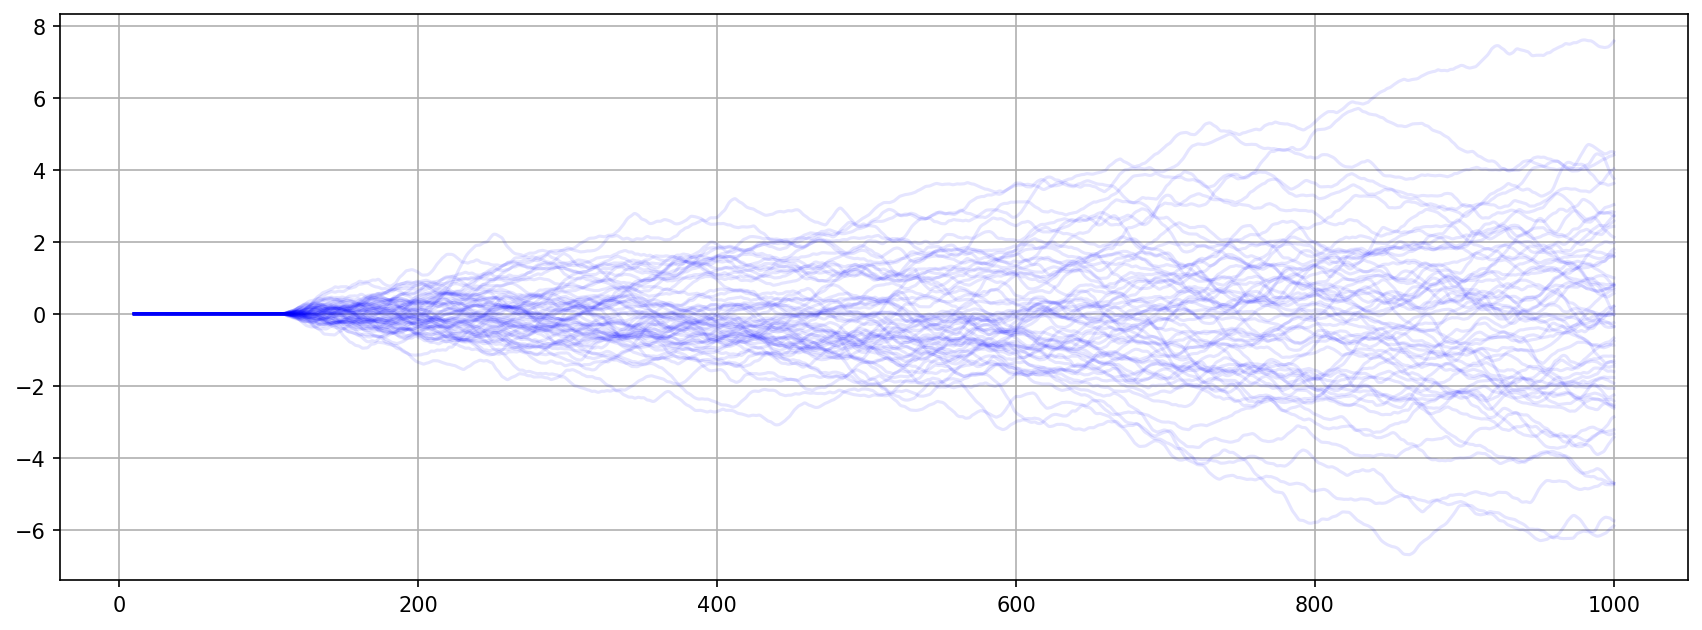

In [24]:
rl = int(10/0.05)
fig = plt.figure(figsize=(14,5))
ax = plt.gca()

(data[1e-7]["L"]-data[0]["L"]).rolling(rl).mean().plot(alpha=0.1, color="blue", ax=ax)

# plt.xlim(-0.5, 1)
plt.grid()
ax.get_legend().remove()

In [29]:
@interact(t=IntSlider(min=0, max=500, step=10, 
                       continuous_update=False))
def f(t):
    L[0].loc[t].plot.kde()
    L[1e-7].loc[t].plot.kde()


interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=500, step=10), Output()…

In [12]:
diff = data[1e-7]["L"] - data[0]["L"]

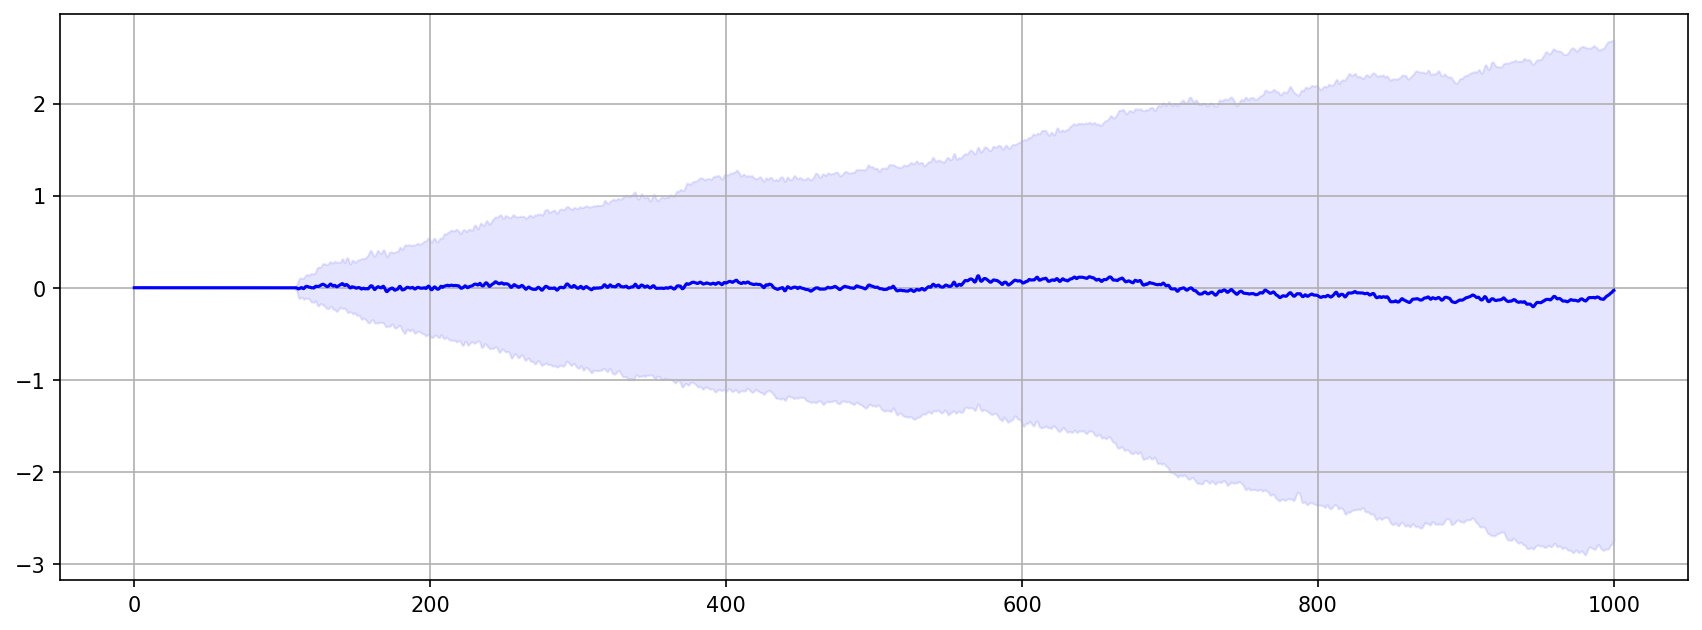

In [13]:
fig = plt.figure(figsize=(14,5))
plot_mean_std(diff.loc[:], color="blue", label=r"diff")
plt.grid()

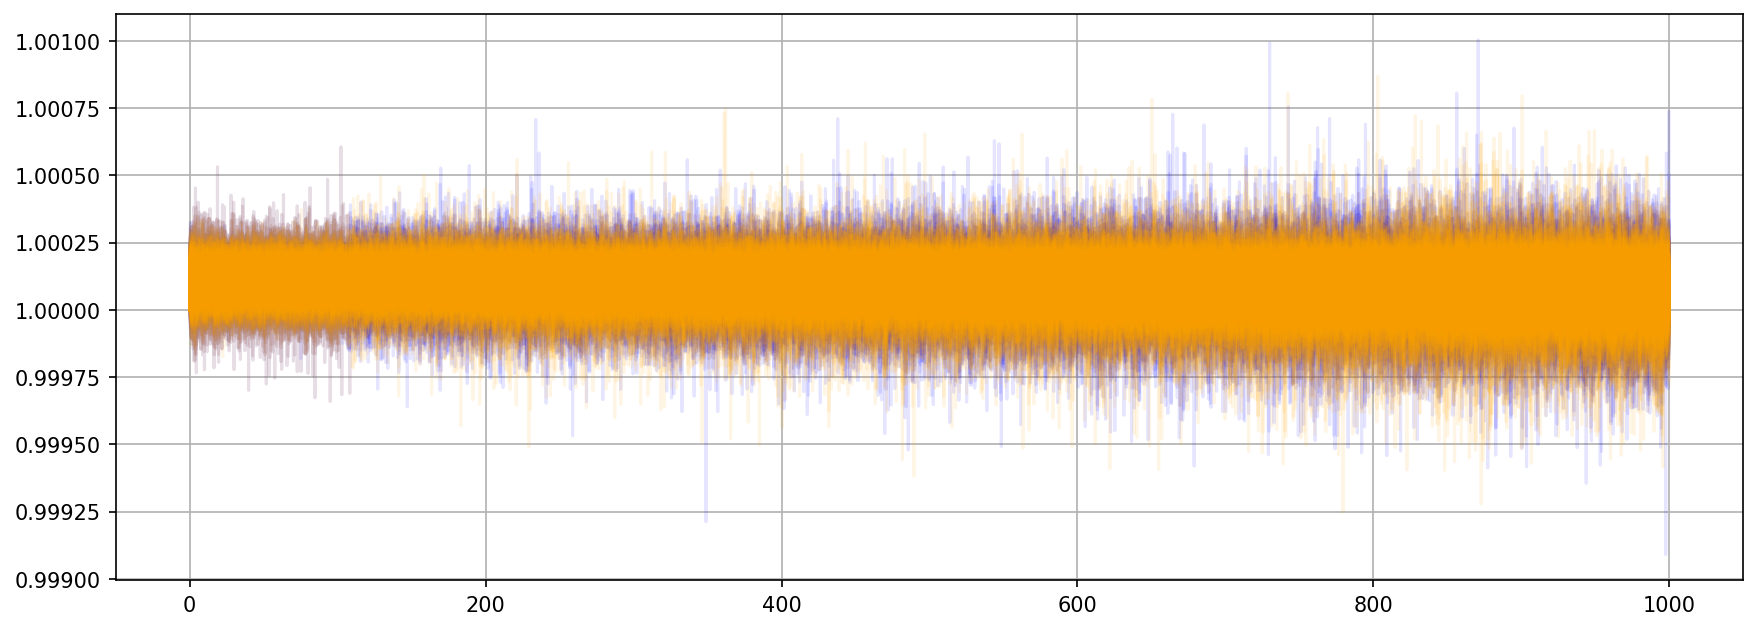

In [26]:
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
(data[0]["E"]/data[0]["E"].iloc[0]).plot(alpha=0.1, color="blue", ax=ax)
(data[1e-7]["E"]/data[1e-7]["E"].iloc[0]).plot(alpha=0.1, color="orange", ax=ax)

# L[2].plot(alpha=0.1, color="orange", ax=ax)
# L[2].plot(alpha=0.1, color="red", ax=ax)
# L[3].plot(alpha=0.1, color="k", ax=ax)
# L[10].plot(alpha=0.1, color="green", ax=ax)

# plt.xlim(-0.5, 1)
plt.grid()
ax.get_legend().remove()

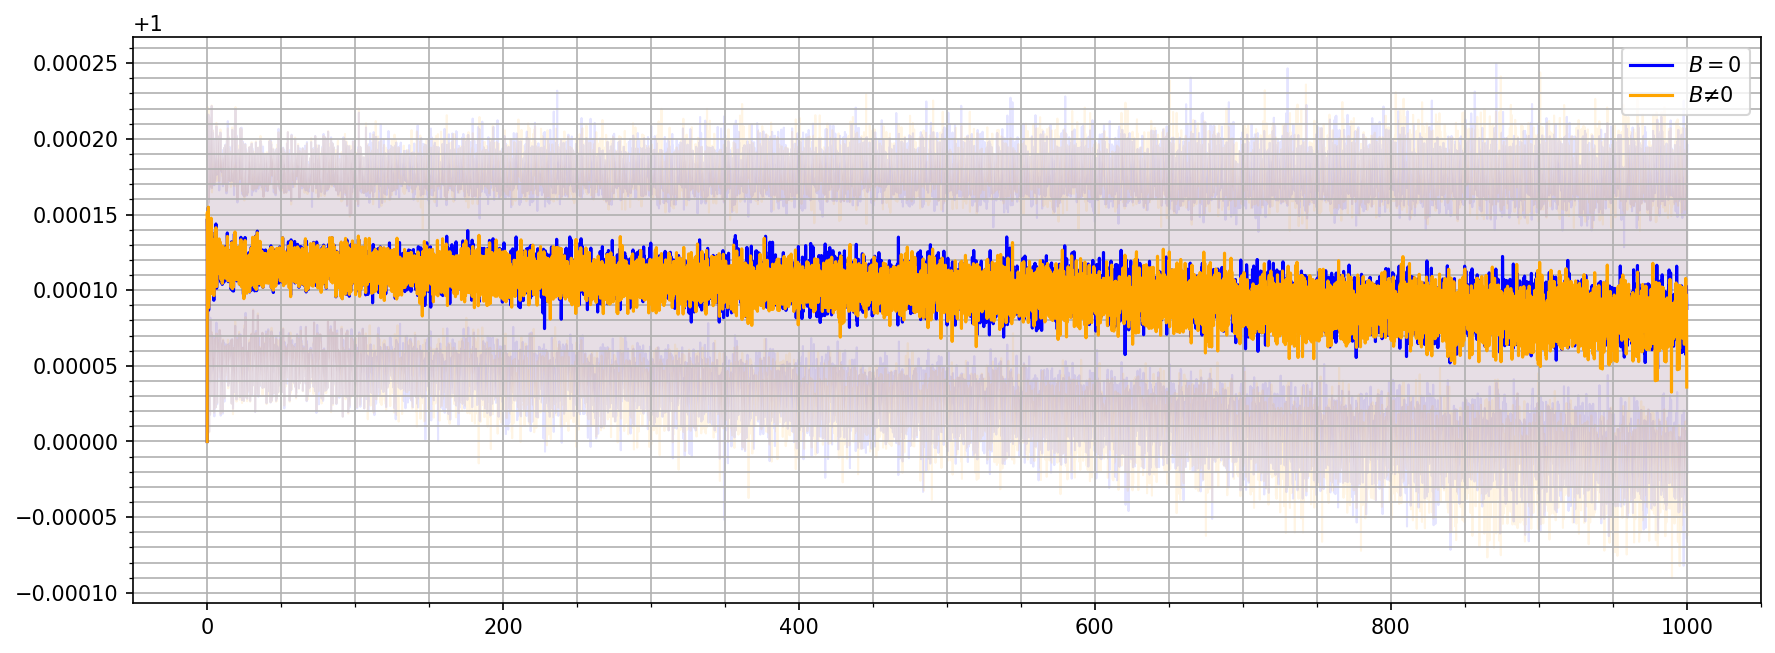

In [27]:
fig = plt.figure(figsize=(14,5))
plot_mean_std((data[0]["E"]/data[0]["E"].iloc[0]), color="blue", label=r"$B=0$")
plot_mean_std((data[1e-7]["E"]/data[1e-7]["E"].iloc[0]), color="orange", label=r"$B\ne 0$")
# plot_mean_std(data[1]["E"], color="red", label=r"$B\ne 0$")

# plt.xlim(-0.5, 1)
plt.grid(which="both")
plt.minorticks_on()
plt.legend()
# ax.get_legend().remove()

In [ ]:
simB0 = SimulatorMagnetic()
simB0.load("simB0_anisotrope_push B-0 N-157 rec-20001 07-05-2022 03-46-13.pkl")
simB0_iso = SimulatorMagnetic()
simB0_iso.load("simB0_isotrope_push B-0 N-151 rec-1001 07-01-2022 10-52-07.pkl")
simB1 = SimulatorMagnetic()
simB1.load('simB1_anisotrope_push B-1 N-157 rec-20001 07-05-2022 03-38-36.pkl')
simB1_iso = SimulatorMagnetic()
simB1_iso.load('simB1_isotrope_push B-1 N-151 rec-1001 07-01-2022 10-52-12.pkl')

In [ ]:
dfs = simB0.get_data_frames(record_interval=0.01)
dfs1 = simB1.get_data_frames(record_interval=0.01)

In [ ]:
ax = dfs["L"].sum(axis=1).plot()
dfs["BInertia"].sum(axis=1).plot(ax=ax)
(dfs["L"] + dfs["BInertia"]).sum(axis=1).plot()
plt.title("L conservation");

In [ ]:
rl=5000
plt.figure(figsize=(14,5))
plt.title("z angular momentum")
ax = plt.gca()

rol = dfs["L"].sum(axis=1).rolling(rl)
rol.mean().plot(alpha=1, ax=ax, label="B=0")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="Blue", alpha=0.3, label="1 std")

rol = dfs1["L"].sum(axis=1).rolling(rl)
rol.mean().plot(alpha=1, ax=ax, label="B=1")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="Orange", alpha=0.3, label="1 std")

plt.grid()
plt.legend()

In [ ]:
plt.figure(figsize=(14,5))
plt.title("z angular momentum")
ax = dfs["L"].sum(axis=1).plot(alpha=0.5, label="window 0 sec")

rol = dfs["L"].sum(axis=1).rolling(300)
rol.mean().plot(alpha=1, ax=ax, label="window 3 sec")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="orange", alpha=0.1, label="1 std")


rol = dfs["L"].sum(axis=1).rolling(5000)
rol.mean().plot(alpha=1, ax=ax, label="window 50 sec")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="green", alpha=0.1, label="1 std")

rol = dfs["L"].sum(axis=1).rolling(10000)
rol.mean().plot(alpha=1, ax=ax, label="window 100 sec")
plt.fill_between(dfs["L"].index, (rol.mean() + rol.std()), (rol.mean() - rol.std()), color="red", alpha=0.1, label="1 std")

# (rol.mean() + rol.std()).plot(alpha=1, ax=ax, label="window 50 sec")
# (rol.mean() - rol.std()).plot(alpha=1, ax=ax, label="window 50 sec")


plt.grid()
plt.legend()
# ax.get_legend().remove()

In [ ]:
plt.figure(figsize=(14,5))
plt.title("Energy (note that x axis is scaled)")
ax = dfs["KE"].sum(axis=1).plot(label="KE")
dfs["PE"].sum(axis=1).plot(ax=ax, label="PE")
dfs["IE"].sum(axis=1).plot(ax=ax, label="IE")
(dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1).plot(label="total")
plt.xlim(-3,30)
plt.legend()
# plt.title("E conservation");

In [ ]:
Ls = dfs["L"].sum(axis=1).loc[100:]
print(Ls.mean(), Ls.std(), len(Ls))

In [ ]:
ax = dfs["L"][range(10)].plot(alpha=0.2)
dfs["L"][range(10)].rolling(100).mean().plot(alpha=1, ax=ax)
ax.get_legend().remove()

In [ ]:
dfs["L"][range(2)].rolling(1).mean().plot()

In [ ]:
ax = dfs["KE"].sum(axis=1).plot()
dfs["PE"].sum(axis=1).plot(ax=ax)
dfs["IE"].sum(axis=1).plot(ax=ax)
(dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1).plot()
plt.title("E conservation");

In [ ]:
dfs["H"] = dfs["KE"] + dfs["PE"] + dfs["IE"]

In [ ]:
plt.hist(dfs["KE"].loc[70:].values.flatten(), bins=100);

In [ ]:
ax = df[df.columns[:20]].plot(alpha=0.1)
df[df.columns[:20]].rolling(1000).mean().plot(ax=ax)
ax.get_legend().remove()